In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as iter
import math
from sklearn.preprocessing import MinMaxScaler
import moo_functions as moo

# Part 3: Decison Making (MODM) 
Finding the Pareto Front is a crucial step to isolate the best solutions, however it's also as far as pure math can take you - once every possible solution is technically "valid", finding the "best" one is a matter of personal preference, or, **decision making**.

**Find Pareto Front first**  
MODM methods are applied to the isolated Pareto front, which we completed in Part 2.  
Retrieving those solutions and creating a normalized version of the dataset for fair analysis:

In [2]:
df = pd.read_csv('best_algo_solns.csv')

In [3]:
# normalization
df_normalized = df.copy()
for col in df.columns:
    df_normalized[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())


## MODM Methods
Different methods can be applied to aid in decision making depending on the type of preferences you/the stakeholder has.

### Method 1: Epsilon Constraint

Optimize one objective while converting the others into hard constraints with specified bounds.  
So we said we wanted as many outfits as possible, but what-if, for reduced complexity, you just said okay, I only really *need* a minimum of 25 different outfits.

In [4]:
#outfits_proportion = 1-(40 / total_possible_outfits)
min_outfits = 25
outfits_subset = df[df["outfits_lost"] <= (max(df["outfits_lost"])-min_outfits)]

In [5]:
import plotly.graph_objects as go

trace1 = go.Scatter3d(x=df["outfits_lost"], y=df["volume"], z=df["liking_diff"], mode='markers', name="Kept Solutions")
trace2 = go.Scatter3d(x=outfits_subset["outfits_lost"], y=outfits_subset["volume"], z=outfits_subset["liking_diff"], mode='markers', name="Discarded Solutions")

y_range = [df['volume'].min(), df['volume'].max()]
z_range = [df['liking_diff'].min(), df['liking_diff'].max()]
Y_plane, Z_plane = np.meshgrid(y_range, z_range)
X_plane = np.full(Z_plane.shape, (max(df["outfits_lost"])-min_outfits))

plane_trace = go.Surface(x=X_plane, y=Y_plane, z=Z_plane, opacity=0.5, showscale=False)

camera = dict(
    eye=dict(x=-2.5, y=-2.5, z=0)
)
fig = go.Figure(data=[trace1, trace2, plane_trace])
fig.update_layout(scene_camera=camera)
fig.update_layout(scene=dict(xaxis_title="Outfits Lost", yaxis_title = "Volume", zaxis_title = "Liking Diff"))
fig.update_layout(height=600,width=800,autosize=False)

fig.show()

Now we're only considering the solutions with 25 outfits (red portion) and since we no longer care about the # of outfits (anything in this subset is fine) that dimensionality is reduced and we can plot in 2d with just the remaining two objectives:

Text(0, 0.5, 'liking_diffs')

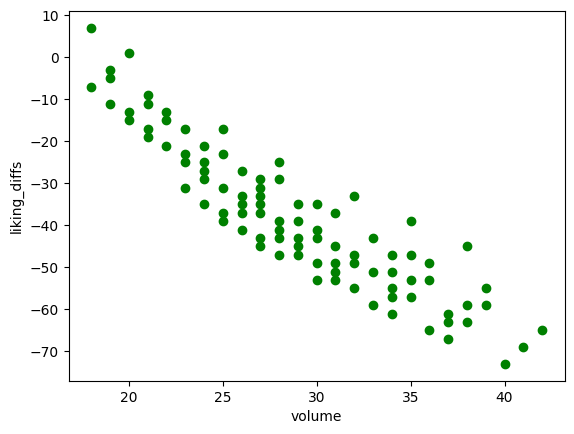

In [6]:
plt.scatter(outfits_subset["volume"], outfits_subset["liking_diff"], color='green')
plt.xlabel("volume")
plt.ylabel("liking_diffs")

Because we have three objectives, by eliminating only one objective we still have an MOCM problem with two objectives and multiple possible solutions, and a new, reduced Pareto Front:

Processing items: 100%|█████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 45089.50it/s]


Text(0, 0.5, 'liking_diffs')

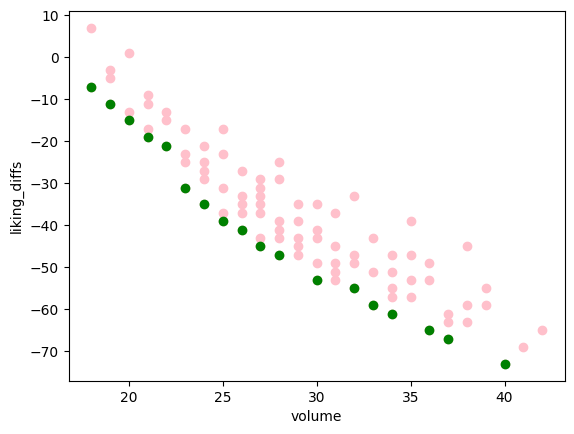

In [7]:
plt.scatter(outfits_subset["volume"], outfits_subset["liking_diff"], color='pink')
plt.scatter(moo.pareto_front(outfits_subset, ["volume", "liking_diff"])["volume"], moo.pareto_front(outfits_subset, ["volume", "liking_diff"])["liking_diff"], color='green')
#plt.scatter(df_normalized.iloc[4]["outfits_lost"], df_normalized.iloc[4]["Disliking"])
plt.xlabel("volume")
plt.ylabel("liking_diffs")

So to get one final solution we still need one more rule.  
Let's say due to airline requirements with the luggage we own, we need volume to be no greater than 20.

In [8]:
max_volume = 20
volume_subset = outfits_subset[outfits_subset["volume"] <= max_volume]
print("Weighted Sum Method Example Solution:\n")
volume_subset.sort_values(by="liking_diff", ascending=True).iloc[0]

Weighted Sum Method Example Solution:



outfits_lost    34.0
volume          20.0
liking_diff    -15.0
Name: 24, dtype: float64

Processing items: 100%|█████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 80340.61it/s]


Text(0, 0.5, 'liking_diffs')

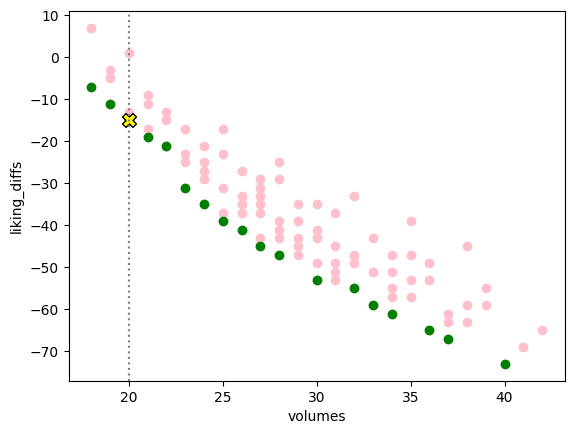

In [9]:
epsilon_soln = volume_subset.sort_values(by="liking_diff", ascending=True).iloc[0]

plt.scatter(outfits_subset["volume"], outfits_subset["liking_diff"], color='pink')
plt.scatter(moo.pareto_front(outfits_subset, ["volume", "liking_diff"])["volume"], moo.pareto_front(outfits_subset, ["volume", "liking_diff"])["liking_diff"], color='green')
plt.axvline(x=max_volume, linestyle='dotted', color='grey')
plt.scatter(epsilon_soln.iloc[1], epsilon_soln.iloc[2], c='yellow', edgecolors="black", marker='X', s=100)
plt.xlabel("volumes")
plt.ylabel("liking_diffs")

This can be visualized in the full feature space:

In [10]:
import plotly.graph_objects as go

trace1 = go.Scatter3d(x=df["outfits_lost"], y=df["volume"], z=df["liking_diff"], mode='markers', name="Sols that don't meet outfit req")
trace2 = go.Scatter3d(x=outfits_subset["outfits_lost"], y=outfits_subset["volume"], z=outfits_subset["liking_diff"], mode='markers', name="Sols that do meet outfit req")
trace3 = go.Scatter3d(x=volume_subset["outfits_lost"], y=volume_subset["volume"], z=volume_subset["liking_diff"], mode='markers', name="Sols that meet both reqs")

y_range = [df['volume'].min(), df['volume'].max()]
z_range = [df['liking_diff'].min(), df['liking_diff'].max()]
Y_plane, Z_plane = np.meshgrid(y_range, z_range)
X_plane = np.full(Z_plane.shape, (max(df["outfits_lost"])-min_outfits))

plane_trace = go.Surface(x=X_plane, y=Y_plane, z=Z_plane, opacity=0.5, showscale=False)


x_range = [df['outfits_lost'].min(), df['outfits_lost'].max()]
X_plane_1, Z_plane_1 = np.meshgrid(x_range, z_range)
Y_plane_1 = np.full(Z_plane.shape, (max_volume))
plane_trace_1 = go.Surface(x=X_plane_1, y=Y_plane_1, z=Z_plane_1, opacity=0.5, showscale=False)

intersect_point = go.Scatter3d(x=[epsilon_soln.iloc[0]], y=[epsilon_soln.iloc[1]], z=[epsilon_soln.iloc[2]], mode='markers', marker=dict(color='yellow', symbol='x'), name="Point with best liking score of those that meet both reqs")


camera = dict(
    eye=dict(x=-2.5, y=-2.5, z=0)
)
fig = go.Figure(data=[trace1, trace2, trace3, plane_trace, plane_trace_1, intersect_point])
fig.update_layout(scene_camera=camera)
fig.update_layout(scene=dict(xaxis_title="Outfits Lost", yaxis_title = "Volume", zaxis_title = "Liking Diff"))
fig.update_layout(height=600,width=800,autosize=False)
fig.show()

The green dots are solutions that fulfill both of our requirements, and within that subset there is one with the best (lowest) liking score, which is the yellow X.  

Method pros: 
* Can recover the entire Pareto front (including non-convex regions)
* Makes tradeoffs explicit via interpretable thresholds
* Strong theoretical foundation in optimization 

Method cons: 
* Requires careful selection of ε values
* Sensitive to feasibility issues
* Produces solutions one-at-a-time, not rankings

### Method 2: Find best composite score
Since lower = better for each of our metrics, hypothetically simply summing the scores across each solution and taking the lowest one could identify a best solution. Effectively collapsing multiple objectives into a single objective using a linear sum.  
Here we'll use the normalized version of the data to not bias towards higher magnitude objectives.

In [11]:
df_composite_score = df_normalized.copy()
df_composite_score['composite_score'] = df_composite_score.sum(axis=1)

In [12]:
df_composite_score.sort_values(by="composite_score")

,outfits_lost,volume,liking_diff,composite_score
50,0.000000,1.000,0.063492,1.063492
73,0.066667,0.975,0.031746,1.073413
63,0.033333,0.925,0.142857,1.101190
114,0.066667,0.925,0.111111,1.102778
83,0.100000,0.900,0.111111,1.111111
...,...,...,...,...
152,0.950000,0.075,0.936508,1.961508
145,1.000000,0.000,0.968254,1.968254
142,0.966667,0.050,0.952381,1.969048
154,0.916667,0.100,0.984127,2.000794


This method has simply identified the full suitcase as the "best" due to it having the lowest composite score.  
While the full suitcase is of course a valid solution, the application of this method to this example doesn't capture the full complexity of premise, since we initially sought to have a suitcase that is better than the full one, and the fact that the full suitcase has the lowest composite score is purely a product of how we chose to compute our metrics. So while this very simple method could be helpful in some instances, here it could be prudent to have more control over how the composite score is calcuated.

#### Method 2.1: Weighted Composite Score

Collapse multiple objectives into a single objective using not a pure sum but a linear combination of weighted criteria.

In [13]:
# Example 1: if you priorize less volume
weights_volume = np.array([0.25, 0.5, 0.25])

scalar_score = df_normalized.values @ weights_volume
best_idx = np.argmin(scalar_score)

print("Weighted Composite Score Method Example 1 solution:\n")
df_normalized.iloc[best_idx]

Weighted Composite Score Method Example 1 solution:



outfits_lost    0.416667
volume          0.575000
liking_diff     0.333333
Name: 33, dtype: float64

In [14]:
# Example 2: if you priorize less volume, and would rather lose more outfits and have more items that you like
weights_liking = np.array([0.1, 0.5, 0.4])

scalar_score = df_normalized.values @ weights_liking
best_idx = np.argmin(scalar_score)

print("Weighted Composite Score Method Example 2 solution:\n")
df_normalized.iloc[best_idx]

Weighted Composite Score Method Example 2 solution:



outfits_lost    0.650000
volume          0.450000
liking_diff     0.396825
Name: 61, dtype: float64

The liking diff is higher than example 1 but only slightly less so, whereas outfits_lost takes a big hit

Pros

* Simple, fast, and intuitive
* Easy to explain mathematically
* Works well for convex Pareto fronts

Cons

* Misses non-convex (unsupported) Pareto solutions
* Highly sensitive to scaling and weights
* Assumes full compensability between objectives

### Method 2.1.1: AHP (Analytic Hierarchy Process)
Derive objective weights from *pairwise comparisons* reflecting decision maker judgments.  
Instead of assigning one weight to each objective off the bat, compare objectives in pairs, solve comparison matrix for eigenvalues, use those as objective weights.

In [15]:
# Example: volume is 4x more important than outfits lost, 2x as important as likings, and likings is 3x more important than outfit loss
A = np.array([
    #outfit #volume #likings
    [1,     1/4,        1/3], #outfit
    [4,     1,         2], #volume
    [3,     1/2,        1] #likings
])

eigvals, eigvecs = np.linalg.eig(A)
weights_ahp = np.real(eigvecs[:, eigvals.argmax()])
weights_ahp /= weights_ahp.sum()

print("Example weights:", weights_ahp)

Example weights: [0.12195719 0.55842454 0.31961826]


In [16]:
scalar_score = df_normalized.values @ weights_ahp
best_idx = np.argmin(scalar_score)

print("AHP Method Example solution:\n")
df_normalized.iloc[best_idx]

AHP Method Example solution:



outfits_lost    0.966667
volume          0.075000
liking_diff     0.841270
Name: 129, dtype: float64

Pros
* Incorporates human judgment directly
* Structured and interpretable weighting process
* Widely used in practice

Cons
* Inconsistency in judgments can invalidate results
* Scalability issues with many criteria
* Subjective and cognitively demanding

### Method 3: Knee-Point Detection
Select the Pareto solution that represents the greatest marginal improvement in one objective for the smallest marginal sacrifice in others.  
Instead of trying to get as close to the ideal as possible via composite score, use Eucliean distance from the ideal point.

In [17]:
df_distance = df_normalized.copy()
ideal = df_distance.min(axis=0) # (0, 0, -75)
df_distance["distance"] = np.linalg.norm(df_distance - ideal, axis=1)
# [["outfits_lost", "volume", "liking_diff"]]
df_distance.sort_values(by="distance")

,outfits_lost,volume,liking_diff,distance
100,0.333333,0.650,0.269841,0.778733
33,0.416667,0.575,0.333333,0.784441
56,0.350000,0.600,0.365079,0.784718
87,0.266667,0.675,0.301587,0.785933
29,0.400000,0.600,0.317460,0.787897
...,...,...,...,...
154,0.916667,0.100,0.984127,1.348623
142,0.966667,0.050,0.952381,1.357930
68,1.000000,0.025,0.920635,1.359483
145,1.000000,0.000,0.968254,1.391947


In [18]:
best_soln_metrics = df_distance.loc[df_distance["distance"].idxmin()]
print("Knee-Point Detection Method solution:\n")
print(best_soln_metrics)

Knee-Point Detection Method solution:

outfits_lost    0.333333
volume          0.650000
liking_diff     0.269841
distance        0.778733
Name: 100, dtype: float64


In [19]:
best_soln = df.loc[df_distance["distance"].idxmin()]
best_soln = best_soln.to_list()

It's called "knee-point" detection because when the solution space is convex, or sort of bulging towards the ideal, the detected point is right on the edge of the "knee" that bulges out:

**3D Representation:**

In [20]:
def create_bounded_sphere(radius=1, bounds=(-1, 1), center=(0, 0, 0)):
    """Create a sphere bounded by axis limits."""
    u = np.linspace(0, 2*np.pi, 50)  # azimuthal angle
    v = np.linspace(0, np.pi, 50)    # polar angle
    u, v = np.meshgrid(u, v)
    
    # Full sphere
    x = radius * np.sin(v) * np.cos(u)
    y = radius * np.sin(v) * np.sin(u)
    z = radius * np.cos(v)
    
    # Clip to bounds
    x = np.clip(x, bounds[0], bounds[1]) + center[0]
    y = np.clip(y, bounds[0], bounds[1]) + center[1]
    z = np.clip(z, bounds[0], bounds[1]) + center[2]
    
    return x, y, z

In [21]:
# with normalized data, better to view knee
trace1 = go.Scatter3d(x=df_normalized["outfits_lost"], y=df_normalized["volume"], z=df_normalized["liking_diff"], mode='markers', marker=dict(size=3), name="Pareto Front")
trace2 = go.Scatter3d(x=[best_soln_metrics["outfits_lost"]], y=[best_soln_metrics["volume"]], z=[best_soln_metrics["liking_diff"]], mode='markers', marker=dict(color='red', size=5), name="Knee-Point Solution")


# trace3 = go.Surface(x=x, y=y, z=z,opacity=0.5, showscale=False)
radius = np.linalg.norm([best_soln_metrics["outfits_lost"], best_soln_metrics["volume"], best_soln_metrics["liking_diff"]] - ideal)
x, y, z = create_bounded_sphere(radius=radius, bounds=(-1, 1), center=(0, 0, 0))
trace3 = go.Surface(x=x, y=y, z=z,opacity=0.5, showscale=False)



camera = dict(
    eye=dict(x=-2, y=1, z=0)
)
fig = go.Figure(data=[trace1, trace2, trace3])
fig.update_layout(scene_camera=camera)

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[0, 1], title='X'),
        yaxis=dict(range=[0, 1], title='Y'),
        zaxis=dict(range=[0, 1], title='Z'),
        aspectmode='cube'
    )
)
fig.update_layout(scene=dict(xaxis_title="Outfits Lost", yaxis_title = "Volume", zaxis_title = "Liking Diff"))
fig.update_layout(height=600,width=800,autosize=False)
fig.show()

The detected best solution has the shortest distance to 0, visualized by it being the first one to touch the sphere radiating from 0. If you rotate the cube around, you can see the Pareto Front forms a sort of convex "knee" shape and the best solution lies on the tip.

**2D Representation**

Text(0, 0.5, 'Dislikings')

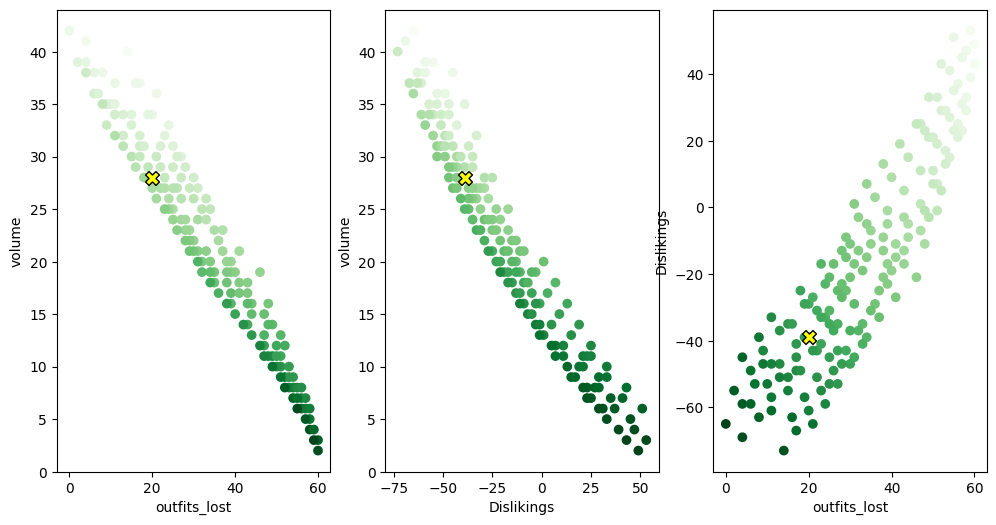

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1,3,1)
plt.scatter(data=df, x="outfits_lost", y="volume", c="liking_diff", cmap='Greens')
plt.scatter(x=[best_soln[0]], y=[best_soln[1]], c='yellow', edgecolors="black", marker='X', s=100)
plt.xlabel("outfits_lost")
plt.ylabel("volume")

plt.subplot(1,3,2)
plt.scatter(data=df, x="liking_diff", y="volume", c="outfits_lost", cmap='Greens')
plt.scatter(x=[best_soln[2]], y=[best_soln[1]], c='yellow', edgecolors="black", marker='X', s=100)
plt.xlabel("Dislikings")
plt.ylabel("volume")

plt.subplot(1,3,3)
plt.scatter(data=df, x="outfits_lost", y="liking_diff", c="volume", cmap='Greens')
plt.scatter(x=[best_soln[0]], y=[best_soln[2]], c='yellow', edgecolors="black", marker='X', s=100)
plt.xlabel("outfits_lost")
plt.ylabel("Dislikings")

It's hard to visualize the "knee" part of it without a 3rd dimension, so just for visualization purposes we'll filter each to be within the bounds of the solution:

Processing items: 100%|███████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 57804.36it/s]


Text(0, 0.5, 'Dislikings')

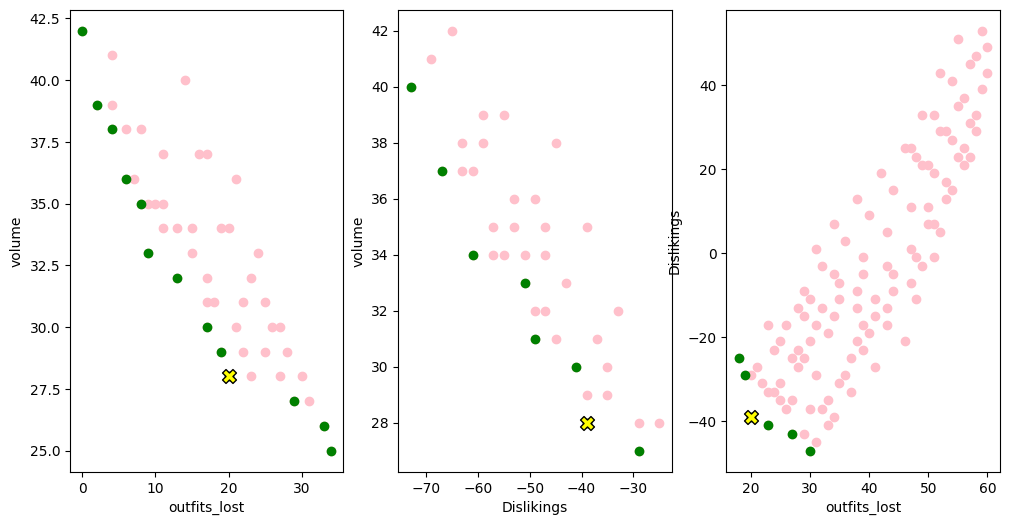

In [23]:
filtered_outfits = df[df["outfits_lost"] <= best_soln[0]]
filtered_vols = df[df["volume"] <= best_soln[1]]
filtered_likings = df[df["liking_diff"] <= best_soln[2]]

plt.figure(figsize=(12, 6))
plt.subplot(1,3,1)
plt.scatter(filtered_likings["outfits_lost"], filtered_likings["volume"], color='pink')
plt.scatter(moo.pareto_front(filtered_likings, ["outfits_lost", "volume"])["outfits_lost"], moo.pareto_front(filtered_likings, ["outfits_lost", "volume"])["volume"], color='green')
plt.scatter(x=[best_soln[0]], y=[best_soln[1]], c='yellow', edgecolors="black", marker='X', s=100)
plt.xlabel("outfits_lost")
plt.ylabel("volume")

plt.subplot(1,3,2)
plt.scatter(filtered_outfits["liking_diff"], filtered_outfits["volume"], color='pink')
plt.scatter(moo.pareto_front(filtered_outfits, ["liking_diff", "volume"])["liking_diff"], moo.pareto_front(filtered_outfits, ["liking_diff", "volume"])["volume"], color='green')
plt.scatter(x=[best_soln[2]], y=[best_soln[1]], c='yellow', edgecolors="black", marker='X', s=100)
plt.xlabel("Dislikings")
plt.ylabel("volume")

plt.subplot(1,3,3)
plt.scatter(filtered_vols["outfits_lost"], filtered_vols["liking_diff"], color='pink')
plt.scatter(moo.pareto_front(filtered_vols, ["outfits_lost", "liking_diff"])["outfits_lost"], moo.pareto_front(filtered_vols, ["outfits_lost", "liking_diff"])["liking_diff"], color='green')
plt.scatter(x=[best_soln[0]], y=[best_soln[2]], c='yellow', edgecolors="black", marker='X', s=100)
plt.xlabel("outfits_lost")
plt.ylabel("Dislikings")

The "knees" are easier to see here but you can imagine with a non-convex solution it run into issues.

Pros
* Requires no explicit preferences or weights
* Identifies natural compromise solutions
* Geometrically intuitive and easy to visualize

Cons
* Definition of “knee” can be ambiguous
* Sensitive to scaling and noise
* May not align with stakeholder priorities

### Method 3b: Reference-Point Decision Making (weighted Knee Point Detection)

Choose the solution closest to an aspirational target point specified by the decision maker.
Instead of defaulting to the ideal point to take point distance from, you can also select a different aspirational point.

In [24]:
reference_point = np.array([0.2, 0.3, 0.3])  # aspirational

chebyshev = np.max(np.abs(df_normalized.values - reference_point), axis=1)
ref_idx = np.argmin(chebyshev)

print("Reference-Point Example solution:\n")
df_normalized.iloc[ref_idx]

Reference-Point Example solution:



outfits_lost    0.433333
volume          0.525000
liking_diff     0.444444
Name: 123, dtype: float64

In [25]:
ref_point_best_soln = df_normalized.iloc[ref_idx].to_list()

In [26]:
df.iloc[ref_idx]

outfits_lost    26.0
volume          23.0
liking_diff    -17.0
Name: 123, dtype: float64

We can visualize the difference by plotting a sphere that radiates from the new aspirational point.

In [27]:
# with normalized data, better to view knee
trace1 = go.Scatter3d(x=df_normalized["outfits_lost"], y=df_normalized["volume"], z=df_normalized["liking_diff"], mode='markers', marker=dict(size=3), name="Pareto Front")
trace2 = go.Scatter3d(x=[ref_point_best_soln[0]], y=[ref_point_best_soln[1]], z=[ref_point_best_soln[2]], mode='markers', marker=dict(color='red', size=5), name="Reference-Point Example solution")


# trace3 = go.Surface(x=x, y=y, z=z,opacity=0.5, showscale=False)
radius = np.linalg.norm([ref_point_best_soln[0], ref_point_best_soln[1], ref_point_best_soln[2]] - reference_point)
x, y, z = create_bounded_sphere(radius=radius, bounds=(-1, 1), center=reference_point)
trace3 = go.Surface(x=x, y=y, z=z,opacity=0.5, showscale=False)



camera = dict(
    eye=dict(x=-2, y=1, z=0)
)
fig = go.Figure(data=[trace1, trace2, trace3])
fig.update_layout(scene_camera=camera)

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[0, 1], title='X'),
        yaxis=dict(range=[0, 1], title='Y'),
        zaxis=dict(range=[0, 1], title='Z'),
        aspectmode='cube'
    )
)
fig.update_layout(scene=dict(xaxis_title="Outfits Lost", yaxis_title = "Volume", zaxis_title = "Liking Diff"))
fig.update_layout(height=600,width=800,autosize=False)

fig.show()

Pros
* Captures non-convex Pareto regions
* Intuitive preference expression (“I want at least this”)
* Strong theoretical grounding (Chebyshev / ASF)

Cons
* Requires meaningful reference point selection
* Sensitive to normalization
* Produces a single solution, not a ranking

### Method 4: TOPSIS (Closeness to Ideal Solution)

Select the solution closest to an ideal point and farthest from a worst-case point in objective space.

In [28]:
ideal = df_normalized.min()
anti_ideal = df_normalized.max()

d_pos = np.linalg.norm(df_normalized - ideal, axis=1)
d_neg = np.linalg.norm(df_normalized - anti_ideal, axis=1)

topsis_score = d_neg / (d_pos + d_neg)
best_idx = np.argmax(topsis_score)

topsis_soln = df_normalized.iloc[best_idx].to_list()
print("TOPSIS Method solution:\n")
df.iloc[best_idx]

TOPSIS Method solution:



outfits_lost    13.0
volume          32.0
liking_diff    -47.0
Name: 113, dtype: float64

In [29]:
trace1 = go.Scatter3d(x=df_normalized["outfits_lost"], y=df_normalized["volume"], z=df_normalized["liking_diff"], mode='markers', marker=dict(size=3), name="Pareto Front")
trace2 = go.Scatter3d(x=[topsis_soln[0]], y=[topsis_soln[1]], z=[topsis_soln[2]], mode='markers', marker=dict(color='red', size=5), name="TOPSIS Solution")


camera = dict(
    eye=dict(x=-2, y=-1, z=0)
)
fig = go.Figure(data=[trace1, trace2])
fig.update_layout(scene_camera=camera)

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[0, 1], title='X'),
        yaxis=dict(range=[0, 1], title='Y'),
        zaxis=dict(range=[0, 1], title='Z'),
        aspectmode='cube'
    )
)
fig.update_layout(scene=dict(xaxis_title="Outfits Lost", yaxis_title = "Volume", zaxis_title = "Liking Diff"))
fig.update_layout(height=600,width=800,autosize=False)
fig.show()

Pros
* Intuitive geometric interpretation
* Produces a complete ranking
* Easy to implement and visualize

Cons
* Assumes Euclidean distance is meaningful
* Sensitive to normalization
* Implicitly compensatory (bad performance can be offset)

### Method 5: ELECTRE (Outranking, Non-Compensatory)

Rank solutions using pairwise outranking relations based on concordance, discordance, and veto thresholds.

In [30]:
def outranks(a, b, weights, veto=0.4):
    concordance = weights[a <= b].sum()
    discordance = np.max(a - b)
    return concordance > 0.6 and discordance < veto


#weights = np.array([0.4, 0.3, 0.3])
weights_electre = weights_ahp
print("Example weights:", weights_ahp)

outrank_counts = []
for i, a in df_normalized.iterrows():
    count = 0
    for j, b in df_normalized.iterrows():
        if outranks(a.values, b.values, weights_electre):
            count += 1
    outrank_counts.append(count)

best_idx = np.argmax(outrank_counts)
print("ELECTRE Method Example solution:\n")
df_normalized.iloc[best_idx]


Example weights: [0.12195719 0.55842454 0.31961826]
ELECTRE Method Example solution:



outfits_lost    0.350000
volume          0.600000
liking_diff     0.365079
Name: 56, dtype: float64

Pros
* Non-compensatory (poor performance cannot be fully offset)
* Handles qualitative and ethical constraints well
* Suitable for policy and regulatory decisions

Cons
* Complex to parameterize and explain
* May produce incomparabilities or partial rankings
* Less intuitive for non-experts

### Method 6: PROMETHEE (Preference Functions)

Compare solutions using preference functions that model the strength of preference across criteria.

In [31]:
def preference(a, b, p=0.001):
    return np.clip((b - a) / p, 0, 1)

flows = []
for i, a in df_normalized.iterrows():
    phi_plus = 0
    phi_minus = 0
    for j, b in df_normalized.iterrows():
        if i != j:
            phi_plus += preference(a.values, b.values).sum()
            phi_minus += preference(b.values, a.values).sum()
    flows.append(phi_plus - phi_minus)

best_idx = np.argmax(flows)
print("PROMETHEE Method Example 1 solution:\n")
df.iloc[best_idx]


PROMETHEE Method Example 1 solution:



outfits_lost     4.0
volume          41.0
liking_diff    -69.0
Name: 73, dtype: float64

Pros
* More flexible than ELECTRE
* Allows gradual tradeoffs via preference functions
* Produces clear rankings and visualizations

Cons
* Requires choosing preference functions and thresholds
* Still subjective in parameter selection
* Can be computationally intensive

### Method 7: Entropy Weighting (Data-Driven Importance)

Assign criterion weights based on their information content or variability in the data.

In [32]:
eps = 1e-9
P = df_normalized / df_normalized.sum()

entropy = -(P * np.log(P + eps)).sum(axis=0) / np.log(len(P))
weights_entropy = (1 - entropy)
weights_entropy /= weights_entropy.sum()

print("Example weights:", weights_entropy)

Example weights: outfits_lost    0.287191
volume          0.336568
liking_diff     0.376241
dtype: float64


In [33]:
scores = df_normalized.values @ weights_entropy
print("Entropy Weighting Method solution:\n")
df_normalized.iloc[np.argmin(scores)]

Entropy Weighting Method solution:



outfits_lost    0.066667
volume          0.975000
liking_diff     0.031746
Name: 73, dtype: float64

Pros
* Fully data-driven and objective
* No decision-maker input required
* Useful when preferences are unknown

Cons
* High variance ≠ high importance
* Ignores semantic meaning of criteria
* Sensitive to noise and outliers

### Method 7: Clustering the Pareto Front

Group Pareto optimal solutions into regions with similar tradeoff profiles to support higher level decision reasoning.
Instead of identifying one best solution or a strict ranking, this creates groups that can be classified and further narrowed individually, e.g. "Group 1: The Extreme Backpacker (very low volume suitcases), Group 2: The Fashionista (very high # of outfits), ..." 

In [34]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(df_normalized)

knn_df = df.copy()

knn_df["Cluster"] = clusters
knn_df.groupby("Cluster").mean()


,outfits_lost,volume,liking_diff
Cluster,,,
0,24.638298,27.340426,-37.042553
1,52.975000,8.425000,26.800000
2,38.088889,18.466667,-10.866667
3,10.827586,35.758621,-54.241379


In [35]:
# with normalized data, better to view knee
trace1 = go.Scatter3d(x=df["outfits_lost"], y=df["volume"], z=df["liking_diff"], \
                      mode='markers', marker=dict(color = knn_df["Cluster"], size=3))


camera = dict(
    eye=dict(x=-2.5, y=-2.5, z=0)
)
fig = go.Figure(data=[trace1])
fig.update_layout(scene_camera=camera)
fig.update_layout(scene=dict(xaxis_title="Outfits Lost", yaxis_title = "Volume", zaxis_title = "Liking Diff"))
fig.update_layout(height=600,width=800,autosize=False)

fig.show()

Pros
* Reduces cognitive overload
* Reveals qualitative solution regimes
* Pairs well with interactive decision-making

Cons
* Choice of number of clusters is subjective
* Does not select a solution by itself
* Sensitive to distance metrics and scaling

We know there's no one best solution, nor would there be value to comparing all the points these methods chose. The purpose of this notebook was simply to show worked examples of many of the popular MODM methods and why/when you would deploy different ones. Here is a brief tabular summary:

| Method       | Compensatory | Needs Weights  | Handles Veto | Intuition  |
| ------------ | ------------ | -------------- | ------------ | ---------- |
| Weighted Sum | Yes          | Yes            | No           | Tradeoffs  |
| TOPSIS       | Yes          | Optional       | No           | Geometry   |
| AHP          | Yes          | Yes (elicited) | No           | Psychology |
| ELECTRE      | No           | Yes            | Yes          | Policy     |
| PROMETHEE    | Partial      | Yes            | Soft         | Economics  |
| Entropy      | Yes          | No             | No           | Statistics |


Part 4 uses all the work we've done to train an LLM model to answer any lingering questions about the examples or how to apply the methods to your own use case.